### **This is the simple workflow with graph**

### **from here phase- 1**

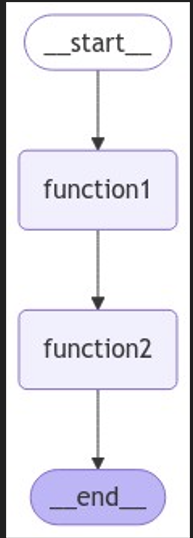

### **Define the state schema**

In [34]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class WorkflowState(TypedDict):
    result: str


## **Define the functions for the graph**

In [35]:
def function1(state: WorkflowState) -> dict:
    return {"result": state["result"] + " from first function"}

def function3(state: WorkflowState) -> dict:
    return {"result": state["result"] + " (via function3)"}

def function2(state: WorkflowState) -> dict:
    # Call function3 internally
    intermediate = function3({"result": "this is function 2 in between"})
    return {"result": state["result"] + " " + intermediate["result"] + " and SURESH BEEKHANI from second function"}


### **Create the StateGraph**

In [36]:
workflow = StateGraph(WorkflowState)

workflow.add_node("node_1", function1)
workflow.add_node("node_2", function2)

# Define edges
workflow.add_edge(START, "node_1")
workflow.add_edge("node_1", "node_2")
workflow.add_edge("node_2", END)


### **Compile and run the workflow**

In [37]:
graph_runnable1 = workflow.compile()

# Initial input
input_state = {"result": "Hello"}

# Run the workflow
result = graph_runnable1.invoke(input_state)
print(result)


{'result': 'Hello from first function this is function 2 in between (via function3) and SURESH BEEKHANI from second function'}


## **Streaming outputs**

In [38]:
for output in graph_runnable1.stream(input_state):
    for node_name, node_output in output.items():
        print(f"Output from node '{node_name}': {node_output}")


Output from node 'node_1': {'result': 'Hello from first function'}
Output from node 'node_2': {'result': 'Hello from first function this is function 2 in between (via function3) and SURESH BEEKHANI from second function'}


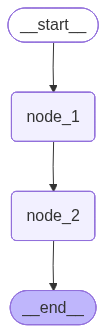

In [39]:
from IPython.display import Image, display

try:
    display(Image(graph_runnable1.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

### **now explain the intermediate function**

##### **then come to the next workflow**

### **from here phase-2**

### **Now let's create a workflow with LLM**

In [40]:
import os
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
os.environ["GROQ_API_KEY"]= GROQ_API_KEY

### **Load Chat Model LLM**

In [41]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.1-8b-instant")
llm.invoke("hi").content

'How can I assist you today?'

## **Define the state schema**

In [42]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


class WorkflowState(TypedDict):
    result: str

## **Define the node functions**

In [43]:
# Node 1: call LLM
def function1(state: WorkflowState) -> dict:
    llm = ChatGroq(model_name="llama-3.1-8b-instant")
    response = llm.invoke(state["result"]).content
    return {"result": response}

# Node 2: convert to uppercase
def function2(state: WorkflowState) -> dict:
    upper_case = state["result"].upper()
    return {"result": upper_case}


### **Build the workflow graph**

In [44]:
workflow = StateGraph(WorkflowState)

# Add nodes
workflow.add_node("llm_node", function1)
workflow.add_node("uppercase_node", function2)

# Connect nodes
workflow.add_edge(START, "llm_node")
workflow.add_edge("llm_node", "uppercase_node")
workflow.add_edge("uppercase_node", END)


In [45]:
graph_runnable2 = workflow.compile()

# Initial input
input_state = {"result": "Hello, how are you?"}


In [46]:

# Run the workflow
final_output = graph_runnable2.invoke(input_state)
print(final_output)

{'result': "I'M FUNCTIONING PROPERLY, THANK YOU FOR ASKING. I'M A LARGE LANGUAGE MODEL, SO I DON'T HAVE FEELINGS IN THE SAME WAY HUMANS DO, BUT I'M HERE AND READY TO HELP WITH ANY QUESTIONS OR INFORMATION YOU MIGHT NEED. WHAT'S ON YOUR MIND?"}


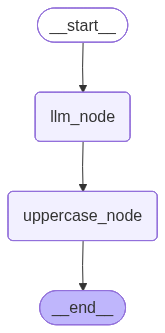

In [47]:
from IPython.display import Image, display

try:
    display(Image(graph_runnable2.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [48]:
# Define the input
input_state = {"result": "what is the name of first pakistan prime minister?"}

# Invoke the compiled graph
final_output = graph_runnable2.invoke(input_state)

# Print the result
print(final_output)


{'result': 'THE FIRST PRIME MINISTER OF PAKISTAN WAS LIAQUAT ALI KHAN. HE SERVED FROM 14 AUGUST 1947 UNTIL HIS ASSASSINATION ON 16 OCTOBER 1951.'}


In [49]:
for output in graph_runnable2.stream(input_state):
    for node_name, node_output in output.items():
        print(f"Output from node '{node_name}': {node_output}")


Output from node 'llm_node': {'result': 'The first Prime Minister of Pakistan was Liaquat Ali Khan. He served as the first and third Prime Minister of Pakistan from 15 August 1947 to 16 October 1951.'}
Output from node 'uppercase_node': {'result': 'THE FIRST PRIME MINISTER OF PAKISTAN WAS LIAQUAT ALI KHAN. HE SERVED AS THE FIRST AND THIRD PRIME MINISTER OF PAKISTAN FROM 15 AUGUST 1947 TO 16 OCTOBER 1951.'}


### **from here phase-3**

### **Can we integrating a RAG Pipeline?**


### **Load Data** 

In [50]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

### **Load embeddings model**

In [51]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings


model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)


### **create a vector databasen retriever**

In [53]:

from langchain_community.vectorstores import Chroma
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 3})

In [58]:
query = "what is meta llama3?"
docs = retriever.invoke(query)
print(docs[0].metadata)
print(docs[0].page_content)

{'source': '..\\data\\llama3.txt'}
Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in


In [59]:
for doc in docs:
    print(doc)

page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': '..\\data\\llama3.txt'}
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': '..\\data\\llama3.txt'}
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': '..\\data\\llama3.txt'}


In [60]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

In [61]:
mydict={}

In [62]:
mydict

{}

In [64]:
mydict["messages"]="hi, how are you?"

In [65]:
mydict

{'messages': 'hi, how are you?'}

In [67]:
mydict["messages"]="hi, what are you doing?"

In [ ]:
mydict

{'messages': 'hi, what are you doing?'}

In [68]:
AgentState={}

In [69]:
AgentState["messages"]=[]

In [70]:
AgentState["messages"].append("hi, how are you?")

In [71]:
AgentState

{'messages': ['hi, how are you?']}

In [ ]:
AgentState["messages"].append("hi, what you doing?")

In [ ]:
AgentState

{'messages': ['hi, how are you?', 'hi, what you doing?']}

In [ ]:
AgentState["messages"][-1]

'hi, what you doing?'

### **what is a work of agent state?** 
### **the work of AgentState is just pass the message to the next node**

In [75]:
from typing_extensions import TypedDict
from typing import List

class AgentState(TypedDict):
    messages: List[str]


In [76]:
def function_1(state: AgentState):
    messages = state["messages"]
    question = messages[-1]

    complete_prompt = (
        "Your task is to provide only the brief answer based on the user query. "
        "Don't include too much reasoning. "
        "Following is the user query: " + question
    )

    response = llm.invoke(complete_prompt)

    # Append LLM response
    state["messages"].append(response.content)

    return state


In [77]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

def function_2(state: AgentState):
    messages = state["messages"]
    question = messages[0]  # original user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    result = retrieval_chain.invoke(question)

    # Append RAG result to state
    state["messages"].append(result)

    return state


In [78]:
from langgraph.graph import StateGraph, START, END

workflow4 = StateGraph(AgentState)

workflow4.add_node("LLM", function_1)
workflow4.add_node("RAGtool", function_2)

workflow4.add_edge(START, "LLM")
workflow4.add_edge("LLM", "RAGtool")
workflow4.add_edge("RAGtool", END)

app4 = workflow4.compile()


In [84]:
input_state = {
    "messages": ["Who was the first Prime Minister of PAKISTAN?"]
}

result = app4.invoke(input_state)

print(result["messages"])


['Who was the first Prime Minister of PAKISTAN?', 'Liaquat Ali Khan.', "I can't answer that question based on the context. The context appears to be about Japan's GDP, but there is no mention of the Prime Minister of Pakistan."]


In [86]:
from IPython.display import Image, display

try:
    display(Image(workflow4.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)


'StateGraph' object has no attribute 'get_graph'


In [87]:
for output in app4.stream(input_state):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'LLM':
---
{'messages': ['Who was the first Prime Minister of PAKISTAN?', 'Liaquat Ali Khan.', "I can't answer that question based on the context. The context appears to be about Japan's GDP, but there is no mention of the Prime Minister of Pakistan.", "I'm not provided with sufficient context to answer your question."]}

---

Output from node 'RAGtool':
---
{'messages': ['Who was the first Prime Minister of PAKISTAN?', 'Liaquat Ali Khan.', "I can't answer that question based on the context. The context appears to be about Japan's GDP, but there is no mention of the Prime Minister of Pakistan.", "I'm not provided with sufficient context to answer your question.", "I can't find any information about a Prime Minister of Pakistan in the given context. The provided context seems to be about the GDP of Japan from 2019 to 2022. It does not contain any information about Pakistan or its Prime Ministers."]}

---



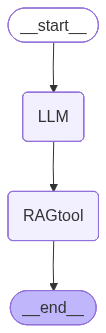

In [88]:
from IPython.display import Image, display

try:
    display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

# from here phase-4

In [116]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain_core.prompts import PromptTemplate

In [95]:
operator.add(10, 15)

25

In [96]:
operator.sub(10, 15)

-5

In [97]:
class AgentState(TypedDict):
    # The 'messages' field should be a sequence of strings, and we annotate it with 'operator.add'
    # This implies we might want to "add" new messages to the sequence later
    messages: Annotated[Sequence[BaseMessage], operator.add]

1. TypedDict:
- TypedDict is a special type that allows you to define a dictionary in Python where each key has a specific type.
It’s useful when you want to enforce type checks on the keys and values of a dictionary.

2. Annotated:
- Annotated is used to add metadata or constraints to a type.
It’s typically used for adding additional information, like constraints or descriptions, to the type.

3. Sequence[BaseMessage]:
- Sequence is a generic type from Python's typing module that represents a list-like structure (such as a list or tuple) where the order matters, and you can access elements by their position.

4. BaseMessage:
- Basemessage: This assumes you're working with the LangChain framework, and BaseMessage is part of its core messaging system. It is typically used when handling or processing messages in LangChain's workflows

5. operator.add:

- operator.add is a function from Python’s operator module that performs addition (+) on its arguments.
In this context, operator.add is being used as metadata for the Annotated type, likely suggesting that the sequence of BaseMessage objects is meant to be "added" or concatenated with another sequence at some point. It’s an indicator of how the messages field will be treated in the logic of your program.

In [104]:
from typing import TypedDict

class Person(TypedDict):
    name: str
    age: int

# Correct usage
person: Person = {
    "name": "Alice",
    "age": 30
}

In [103]:
person["name"]

'Alice'

In [ ]:
person["age"]

30

### **Putting It All Together:**

- The line messages: Annotated[Sequence[BaseMessage], operator.add] defines a field messages that:

- Must be a sequence (like a list or tuple) of BaseMessage objects.
Has the additional annotation operator.add, which suggests that this sequence is intended to support addition (i.e., concatenation of multiple sequences of messages).

messages: Annotated[Sequence[BaseMessage], operator.add]

"messages": [BaseMessage("Hello!", "Alice"), BaseMessage("Hi!", "Bob")]

1. BaseModel (from Pydantic)
- BaseModel is the base class from which all Pydantic models inherit.
- It provides built-in validation, serialization, and parsing of data.
- When you create a class that inherits from BaseModel, you are essentially defining a data model with strict type checks.

**Pydantic is a Python library for data validation and settings management using Python-type annotations. It ensures that the data you work with matches your specified data types, simplifying error handling and data parsing in Python applications.**

https://docs.pydantic.dev/latest/

##### The BaseModel class is used for data validation and settings management in Pydantic. It's the core class that helps define data models, ensuring that attributes follow specific types and validation rules.

2. Field
The Field function is used to provide additional metadata for each field in the model. You can use it to:

- Add descriptions (as seen here).
- Set default values.
- Add validators (e.g., minimum length).
- Add constraints (like making a field optional or required).

#### Important Classes and Functions:
- BaseModel: The core class for defining data models.
- Field: Provides additional metadata and validation for model fields.
- ValidationError: Raised when validation fails.
- Constrained Types: constr, conint, conlist, etc., for restricting field values.
- Predefined Types: EmailStr, AnyUrl, HttpUrl, etc., for common validations.
- RootValidator: Used for validating the entire model or handling field interdependencies.
- Config: Model configuration options.
- parse_obj, parse_raw: Functions to parse data into models.
- validate_arguments: A decorator for function argument validation.
- Strict Types: Enforces exact type validation.

### **from pydantic import BaseModel,Filed,ValidationError,EmailStr,root_validator,validate_arguments,StrictInt**

In [105]:
from pydantic import BaseModel

# Define a Pydantic model
class User(BaseModel):
    id: int
    name: str
    email: str

# Create an instance of the model with valid data
user = User(id=1, name="Alice", email="alice@example.com")

# Access the attributes
print(user.name)  # Output: Alice


Alice


In [106]:
# Automatic validation for types
try:
    invalid_user = User(id="abc", name="Bob", email="bob@example.com")
except Exception as e:
    print(f"Error: {e}")

Error: 1 validation error for User
id
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='abc', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/int_parsing


In [107]:
from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [108]:
Topic: str = Field(description='Selected Topic')

In [109]:
Topic

FieldInfo(annotation=NoneType, required=True, description='Selected Topic')

## **just to check the pydantic**

In [110]:
from pydantic import ValidationError

# Valid data
data = {
    "Topic": "Artificial Intelligence",
    "Reasoning": "It's a rapidly growing field with many advancements."
}

# Parsing and validating the data using the Pydantic model
try:
    topic_selection = TopicSelectionParser(**data)
    print(topic_selection.Topic)  # Output: Artificial Intelligence
    print(topic_selection.Reasoning)  # Output: It's a rapidly growing field with many advancements.
except ValidationError as e:
    print(e)

Artificial Intelligence
It's a rapidly growing field with many advancements.


In [112]:
# Invalid data (Reasoning is not a string)
invalid_data = {
    "Topic": "Artificial Intelligence",
    "Reasoning": 12345  # Invalid type, should be a string
}

# This will raise a validation error
try:
    topic_selection = TopicSelectionParser(**invalid_data)
    print(topic_selection.Topic)  # Output: Artificial Intelligence
    print(topic_selection.Reasoning)  # Output: It's a rapidly growing field with many advancements.
except ValidationError as e:
    print(e)  # This will print a detailed error message about the invalid field

1 validation error for TopicSelectionParser
Reasoning
  Input should be a valid string [type=string_type, input_value=12345, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type


- **TopicSelectionParser:** A Pydantic model that defines two fields (Topic and Reasoning), both of which are required to be strings.
- **Field:** Adds metadata, like descriptions, and can also be used for validation and constraints.
- **Pydantic’s Role:** Ensures that the data matches the expected structure and types, raising validation errors if the data is invalid.

In [118]:
from langchain_classic.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [119]:
parser

PydanticOutputParser(pydantic_object=<class '__main__.TopicSelectionParser'>)

In [120]:
parser.parse

<bound method PydanticOutputParser.parse of PydanticOutputParser(pydantic_object=<class '__main__.TopicSelectionParser'>)>

In [121]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [ ]:
{"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}

the object {"foo": ["bar", "baz"]}

In [117]:
# Example prompt template for topic selection
prompt_template = PromptTemplate(
    input_variables=["user_input"],
    template="Based on the input: {user_input}, please select a topic and provide reasoning."
)

# Simulate generating an output (in a real scenario, this would be from an LLM)
user_input = "Discuss advancements in AI."
output = {
    "Topic": "Advancements in AI",
    "Reasoning": "AI has significantly improved in recent years due to advances in deep learning."
}

# Parse the output using the PydanticOutputParser
try:
    # Instead of directly parsing, create an instance of TopicSelectionParser
    parsed_result = TopicSelectionParser(**output)
    # Alternatively, if you prefer to use PydanticOutputParser:
    # parsed_result = parser.parse(output)  # This will not work since output is a dict, not a string

    # Display the parsed result
    print(parsed_result)

except Exception as e:
    print(f"Error: {e}")

Topic='Advancements in AI' Reasoning='AI has significantly improved in recent years due to advances in deep learning.'


In [123]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters.character import RecursiveCharacterTextSplitter
loader2=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
docs2=loader2.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs2 = text_splitter.split_documents(documents=docs2)
doc_strings2 = [doc.page_content for doc in new_docs2]

db2 = Chroma.from_documents(new_docs2, embeddings)
retriever2 = db2.as_retriever(search_kwargs={"k": 3})

query = "Tell me about Japan's Industrial Growth?"
docs = retriever2.invoke(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': '..\\data\\japan.txt'}
Industrial revival hope for Japan
page_content='Industrial revival hope for Japan' metadata={'source': '..\\data\\japan.txt'}
page_content='Industrial revival hope for Japan' metadata={'source': '..\\data\\japan.txt'}
page_content='Industrial revival hope for Japan' metadata={'source': '..\\data\\japan.txt'}


In [124]:
from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [125]:
from langchain_classic.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [134]:
def function_1(state):
    messages = state["messages"]
    question = messages[-1]   # string

    print(question)

    template = """
    You are a classification assistant.

    Classify the user query into one of the following categories:
    [Japan, Sports, Not Related]

    Provide a brief reasoning for your choice.

    User query: {question}

    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={
            "format_instructions": parser.get_format_instructions()
        }
    )

    chain = prompt | llm | parser

    response = chain.invoke({
        "question": question
    })

    print(response)
    # Example:
    # TopicSelectionParser(
    #   Topic="Japan",
    #   Reasoning="The query asks about industrial growth in Japan."
    # )

    return {
        "messages": [response.Topic],
        "reasoning": response.Reasoning
    }


In [136]:
state = {
    "messages": ["Tell me about Japan's Industrial Growth"]
}

function_1(state)


Tell me about Japan's Industrial Growth
Topic='Japan' Reasoning="The query is about Japan's Industrial Growth, which is primarily related to Japan's economy and industry, a key aspect of the country."


{'messages': ['Japan'],
 'reasoning': "The query is about Japan's Industrial Growth, which is primarily related to Japan's economy and industry, a key aspect of the country."}

In [137]:
function_1(state)

Tell me about Japan's Industrial Growth
Topic='Japan' Reasoning="The query mentions 'Japan', a country, which indicates that the topic is related to Japan."


{'messages': ['Japan'],
 'reasoning': "The query mentions 'Japan', a country, which indicates that the topic is related to Japan."}

In [138]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

In [139]:
def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [140]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'Japan' in last_message or 'Sports' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [141]:
from langgraph.graph import StateGraph,END

workflow5 = StateGraph(AgentState) ### StateGraph with AgentState

In [142]:
workflow5.add_node("agent", function_1)

In [143]:
workflow5.add_node("RAG", function_2)

In [144]:
workflow5.add_node("LLM", function_3)

In [145]:
workflow5.set_entry_point("agent")

In [146]:
workflow5.add_conditional_edges(
    "agent",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

In [147]:
workflow5.add_edge("RAG",END)

In [148]:
workflow5.add_edge("LLM",END)

In [149]:
app5=workflow5.compile()

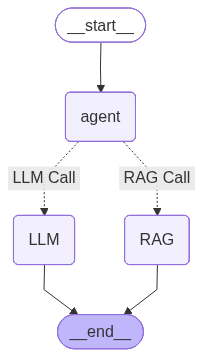

In [150]:
from IPython.display import Image, display

try:
    display(Image(app5.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [151]:
inputs = {"messages": ["Tell me about Japan's Industrial Growth"]}

In [152]:
output = app5.invoke(inputs)

Tell me about Japan's Industrial Growth
Topic='Japan' Reasoning="The query 'Tell me about Japan's Industrial Growth' is related to Japan as it specifically asks about the country's industrial growth."
-> Router ->
Japan
-> Calling RAG ->


In [153]:
output

{'messages': ["Tell me about Japan's Industrial Growth",
  'Japan',
  'Based on the provided context, it appears that Japan is experiencing an industrial revival. The phrase "Industrial revival hope for Japan" is repeated three times, suggesting a recurring theme of growth and revitalization in Japan\'s industrial sector.']}

In [157]:
inputs = {"messages": ["Tell me about first prime minister of Pakistan?"]}

In [158]:
output = app5.invoke(inputs)

Tell me about first prime minister of Pakistan?
Topic='Not Related' Reasoning="The query is about the first prime minister of Pakistan, which is a historical/political topic related to Pakistan. However, none of the specified categories (Japan, Sports) match this topic, making it 'Not Related'."
-> Router ->
Not Related
-> Calling LLM ->


In [159]:
output

{'messages': ['Tell me about first prime minister of Pakistan?',
  'Not Related',
  "The first prime minister of Pakistan was Liaquat Ali Khan. He served as the first Prime Minister of Pakistan from 15 August 1947 until his assassination on 16 October 1951. \n\nLiaquat Ali Khan was a close ally of Muhammad Ali Jinnah, the founder of Pakistan. He played a significant role in shaping the country's early years and was a key figure in Pakistan's government during its initial years of independence.\n\nDuring his tenure, Liaquat Ali Khan implemented several key policies, including the establishment of the Pakistan Industrial Development Corporation, the creation of the Pakistan Institute of International Affairs, and the establishment of the country's first five-year plan.\n\nHe also worked to establish good relations with neighboring countries and the international community, and played a key role in the formation of the Colombo Plan, a regional economic cooperation initiative.\n\nLiaquat A

### **from here phase-5**

In [160]:
import json
#from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_tool

In [161]:
@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers together."""
    return first_number * second_number

In [162]:
tools=[convert_to_openai_tool(multiply)]

In [163]:
model_with_tools = llm.bind(tools=tools)

In [164]:
response = model_with_tools.invoke('What is 35 * 46?')

In [165]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fqacq79p1', 'function': {'arguments': '{"first_number":35,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 228, 'total_tokens': 249, 'completion_time': 0.029548726, 'completion_tokens_details': None, 'prompt_time': 0.014800701, 'prompt_tokens_details': None, 'queue_time': 0.005254487, 'total_time': 0.044349427}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c38d5-da56-7272-acb4-48dbfb5fafb0-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 35, 'second_number': 46}, 'id': 'fqacq79p1', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 228, 'output_tokens': 21, 'total_tokens': 249})

In [166]:
tool_calls = response.additional_kwargs.get('tool_calls')

In [167]:
tool_calls

[{'id': 'fqacq79p1',
  'function': {'arguments': '{"first_number":35,"second_number":46}',
   'name': 'multiply'},
  'type': 'function'}]

In [168]:
for tool_call in tool_calls:
    print('Function Name:',tool_call.get('function').get('name'))
    print('Function Arguments:',tool_call.get('function').get('arguments'))
    print(tool_call)

Function Name: multiply
Function Arguments: {"first_number":35,"second_number":46}
{'id': 'fqacq79p1', 'function': {'arguments': '{"first_number":35,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}


In [169]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [170]:
def invoke_model(state):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [171]:
def invoke_tool(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    print(f"here is a tool_calls {tool_calls}")
    multiply_call = None

    for tool_call in tool_calls:
        if tool_call.get("function").get("name") == "multiply":
            multiply_call = tool_call

    if multiply_call is None:
        raise Exception("No adder input found.")

    res = multiply.invoke(
        json.loads(multiply_call.get("function").get("arguments"))
    )

    return {"messages" : [res]
    }

In [172]:
from langgraph.graph import StateGraph,END
workflow6 = StateGraph(AgentState) ### StateGraph with AgentState
workflow6.add_node("agent", invoke_model)
workflow6.add_node("tool", invoke_tool)
workflow6.add_edge("tool", END)
workflow6.set_entry_point("agent")

In [173]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "multiply"
    else:
        return "end"

workflow6.add_conditional_edges("agent", router, {
    "multiply": "tool",
    "end": END,
})

In [174]:
app6 = workflow6.compile()

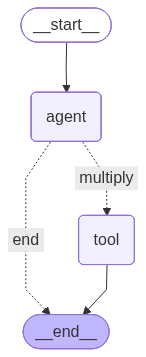

In [175]:
from IPython.display import Image, display

try:
    display(Image(app6.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [176]:
input1={"messages": ["What is 123 * 456?"]}

In [177]:

output = app6.invoke({"messages": ["What is 123 * 456?"]})

here is a tool_calls [{'id': 'zzh8drk9g', 'function': {'arguments': '{"first_number":123,"second_number":456}', 'name': 'multiply'}, 'type': 'function'}]


In [178]:
output['messages'][-1]

56088

In [184]:
output = app6.invoke({"messages": ["What is LLM?"]})

In [185]:
print(output['messages'][-1])

content='brave_search{"query": "LLM definition"}' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 225, 'total_tokens': 237, 'completion_time': 0.022993794, 'completion_tokens_details': None, 'prompt_time': 0.012673405, 'prompt_tokens_details': None, 'queue_time': 0.005161958, 'total_time': 0.035667199}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019c38da-8562-7721-8462-b06161738014-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 225, 'output_tokens': 12, 'total_tokens': 237}


In [182]:
input={"messages": ["What is LLM?"]}

In [183]:
for output in app6.stream(input1):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8k224y3vf', 'function': {'arguments': '{"first_number":123,"second_number":456}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 228, 'total_tokens': 249, 'completion_time': 0.038953374, 'completion_tokens_details': None, 'prompt_time': 0.015009664, 'prompt_tokens_details': None, 'queue_time': 0.011438684, 'total_time': 0.053963038}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c38da-34ae-7203-90cd-f177c4aa461a-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 123, 'second_number': 456}, 'id': '8k224y3vf', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 228, 'output_tokens': 21, 'total_tokens': 249})]}


here is 